# Guitar Classifier - Grad-CAM Analysis

For unknown reasons the model get corrupted when cells a run twice. Thus, if you want to repeat the output first restart the kernel. If you know why this happens let me know!

Model and labels are at this dropbox link:  
https://www.dropbox.com/sh/xsp9uwo9ml96imq/AADSfZZa4joSlI5lql35Wl8ca?dl=0

Copy all files into a folder 'models'

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai import *
from fastai.vision import *
import matplotlib
import numpy as np
import scipy.ndimage
import PIL

In [3]:
# fastai lib is fast evolving, check version number
print(fastai.__version__)

1.0.22


In [4]:
MODEL   = 'v0.1-stage-3-50.pth'
CLASSES = 'v0.1-stage-3-50.cls'

In [5]:
# read class labels
labels = []
names = {}
with open("models/%s" % CLASSES) as fc:
    for line in fc:
        label, full_name = line.split(',')
        label = label.strip()
        labels.append(label)
        names[label] = full_name.replace('"','').strip()

## Load and setup the model

In [6]:
# TODO: load labels
path = Path("/tmp")
data = ImageDataBunch.single_from_classes(path, labels, tfms=get_transforms(max_warp=0.0), size=299).normalize(imagenet_stats)
learn = create_cnn(data, models.resnet50)
learn.model.eval();
learn.model.load_state_dict(
    torch.load("models/%s" % MODEL, map_location="cpu")
)

def one_hot_encode(i):
    onehot = torch.zeros(data.c)
    onehot[i] = 1
    return onehot

In [7]:
# select layer to grab activations from (last Conv2d)
target_layer = learn.model[0][-1][-1]
display(target_layer)

fmap_hook = fastai.callbacks.hook_output(target_layer)

def gradient_torch_hook(self, grad_input, grad_output):
    return grad_input

gradient_hook = fastai.callbacks.Hook(target_layer, gradient_torch_hook, is_forward=False);

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
)

# Load image and predict

In [8]:
fname = 'models/Stratocaster-vs-Les-Paul-Header.jpg'

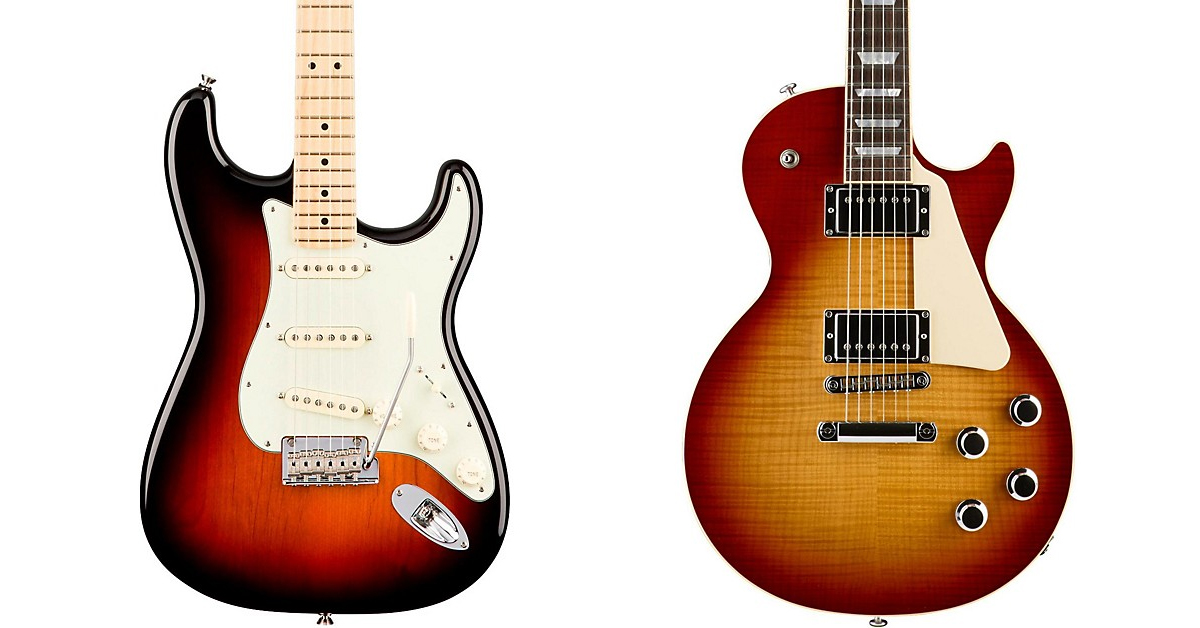

'Gibson Les Paul'

tensor([1.0597e+03, 1.4790e+03, 2.3765e+00, 3.1091e-02, 3.7352e-02, 8.4475e-02,
        3.8758e+01, 3.7386e-01, 3.6495e-02, 1.1332e-02, 1.2291e-01])

In [9]:
# load image and predict
img = open_image(fname)
pred_class, pred_idx, outputs = learn.predict(img)
display(img); display(names[pred_class]); display(outputs)

## Calculate the Class Activation Mapping

In [10]:
learn.data.valid_ds.set_item(img)
tensor_img = list(learn.dl())[0][0]
out = learn.model(tensor_img); out

tensor([[ 6.9657,  7.2991,  0.8656, -3.4708, -3.2874, -2.4713,  3.6573, -0.9839,
         -3.3106, -4.4801, -2.0963]], device='cuda:0',
       grad_fn=<ThAddmmBackward>)

In [11]:
data_cam = []

for i in range(11):
    # get gradients for predicted class
    onehot = torch.zeros(data.c) # setup empty tensor based on number of classes
    onehot[i] = 1
    #onehot[torch.argmax(out)] = 1. # one-hot-encode predicted class
    out.backward(gradient=onehot.reshape(1, -1).cuda(), retain_graph=True) # backpropagate onehot encoding to get gradients

    gradients = next(iter(gradient_hook.stored))
    gradient_linearization = gradients.cpu().numpy().sum((2,3)).reshape(-1) # sum up gradients and linearize
    
    _, n, w, h = gradients.shape
    fmaps = fmap_hook.stored.cpu().numpy().reshape(n, w, h) # reshape activations
    heatmap = np.maximum(0, np.einsum('i, ijk', gradient_linearization, fmaps)) # multiply summed gradients with the gradients to get the heatmap
    
    heatmap_299 = scipy.ndimage.interpolation.zoom(heatmap, (299/10, 299/10), order=3)
    data_cam.append(heatmap_299)


## Plotting

In [12]:
def create_custom_cmap():
    # get colormap and cut off top 10% (black)
    cmapIn = plt.get_cmap('hot_r')
    minval = 0
    maxval = 0.9
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmapIn.name, a=minval, b=maxval),
        cmapIn(np.linspace(minval, maxval, n)))
    return new_cmap
    
def add_panel_label(ax, i=None, p=None):
    bbox_props = dict(boxstyle="square", fc="w", ec="0.5", alpha=1.0)
    idx = p if p else i-1
    return ax.text(150, 0, names[labels[idx]], ha="center", va="center", size=10, bbox=bbox_props)

In [13]:
def scale_data(d, dminmax=None):
    if dminmax:
        dmin, dmax = dminmax
    else:
        dmin = d.min(); dmax = d.max()
    return (d - dmin)/(dmax-dmin)

In [14]:
# raw image
raw_img = np.transpose(tensor_img.squeeze(), (1, 2, 0))
raw_img = scale_data(raw_img)

new_cmap = create_custom_cmap()

In [15]:
def plot_prediction(data_cls, pred_idx, outname='plot_predict.png', ptype=None):
    fig, axes = plt.subplots(1, 2, figsize=(8,4))

    axes[0].imshow(raw_img.numpy())
    axes[1].imshow(raw_img[...,2], cmap="Greys_r", alpha=.25)

    if ptype == 'gcam':
        data_cls_scaled = scale_data(data_cls)
        d = data_cls_scaled[...,np.newaxis]

        rgba = new_cmap(d.squeeze())

        # set alpha channel
        rgba[..., -1] = d.squeeze() * 0.75 
        axes[1].imshow(rgba)
    elif ptype == 'gbp':
        axes[1].imshow(scale_data(data_cls)) #, cmap=matplotlib.cm.jet)
    elif ptype == 'combi':
        axes[1].imshow(data_cls)
    else:
        raise NotImplementedError
    
    
    add_panel_label(axes[1], p=pred_idx)

    for i in range(2):
        axes[i].get_xaxis().set_ticks([])
        axes[i].get_yaxis().set_ticks([])
    plt.savefig(outname, bbox_inches='tight')

In [16]:
def plot_panel(data_cls, outname='plot_panels.png', ptype=None):
    """Hard coded for 1+11 panels at the moment"""
    fig, axes = plt.subplots(3, 4, figsize=(10,8))

    # overall min, max
    min_all = min([x.min() for x in data_cls])
    max_all = max([x.max() for x in data_cls])

    # iterate over all classes and plot grad-CAM for each
    for i, ax in enumerate(axes.flat):
        if i == 0:
            # raw image
            ax.imshow(raw_img.numpy())
        else:
            if ptype == 'gcam':    
                # raw img channel as backdrop, cam as feature map on top
                ax.imshow(raw_img[...,2], cmap="Greys_r", alpha=.25)
                data_cls_scaled = scale_data(data_cls[i-1], (min_all, max_all))
                d = data_cls_scaled[...,np.newaxis]
                rgba = new_cmap(d.squeeze())

                # set alpha channel
                rgba[..., -1] = d.squeeze() * 0.75 
                ax.imshow(rgba)
            elif ptype == 'gbp':
                data_cls_scaled = scale_data(data_cls[i-1], (min_all, max_all))
                ax.imshow(data_cls_scaled) 
            elif ptype == 'combi':
                ax.imshow(data_cls[i-1]) 
                
            add_panel_label(ax, i)

        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
    plt.savefig(outname, bbox_inches='tight')


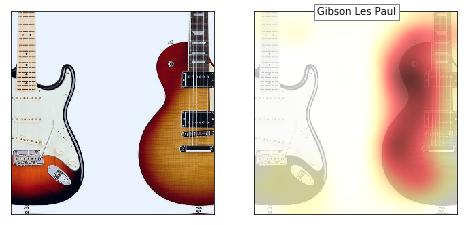

In [17]:
# identify prediction index (negative since we want biggest first)
idx = np.argsort( -1 * torch.nn.functional.softmax(out, dim=1).cpu().detach().numpy()[0] )[0]
plot_prediction(data_cam[idx], idx, ptype='gcam')

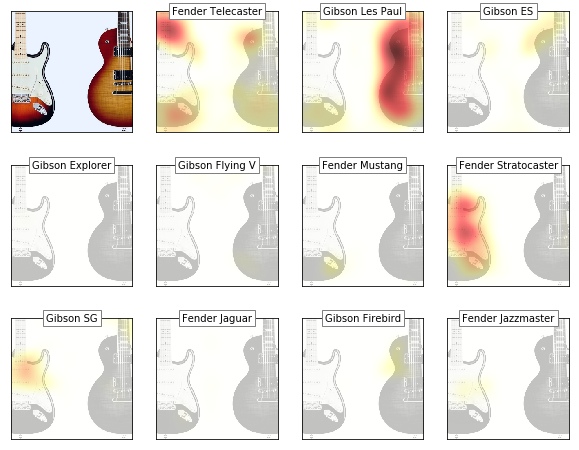

In [18]:
plot_panel(data_cam, ptype='gcam')

# Guided Backprop

The heatmap is constrained by the resolution of the feature maps (in our example 10x10).
A first idea would be to naively compute the backprop the gradients of our "forced score" all the way to the image, and see which pixel has higher gradients.

In [19]:
def image_from_tensor(imagetensor):
    numpied = torch.squeeze(imagetensor)
    numpied = np.moveaxis(numpied.cpu().numpy(), 0 , -1)
    numpied = numpied - np.min(numpied)
    numpied = numpied/np.max(numpied)
    return numpied

In [20]:
data_gbp = []
learn.model.zero_grad()

for i in range(11):
    one_hot = one_hot_encode(i)
    
    # set model to compute the gradients wrt the image:
    tensor_img.requires_grad_()

    # perform perform our forward and backward passes, with gradient == 1 for class
    out = learn.model(tensor_img)

    out.backward(gradient=onehot.reshape(1, -1).cuda())
    data_gbp.append(image_from_tensor(tensor_img.grad))

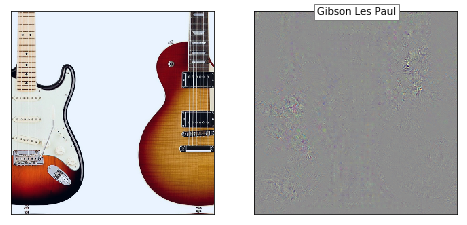

In [21]:
plot_prediction(data_gbp[idx], idx, ptype='gbp', outname='plot_predict_gbp.png')

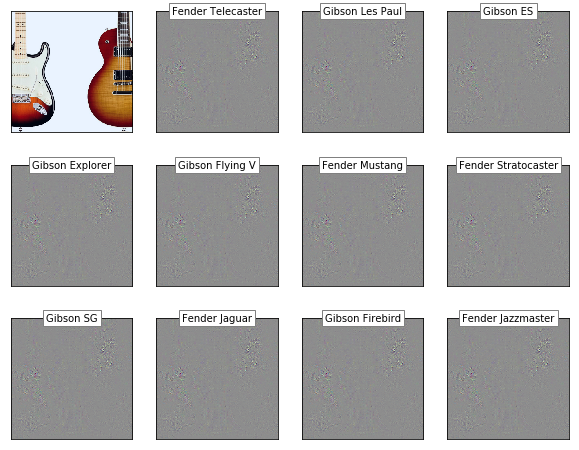

In [22]:
plot_panel(data_gbp, ptype='gbp', outname='plot_panels_gbp.png')

## Guided Grad-CAM

Well, there is something - but no objects are detectable. This is caused by interference of the neurons during backpropagation.
[The Striving for Simplicity: the All Convolutional Net](https://arxiv.org/abs/1412.6806) paper introduced the concept of Guided Backpropagation. The idea, to avoid interference is to simply retain the positive contributions to the gradient while back-propagating, thereby avoiding all interference.
The idea is to clip all negative gradients at each ReLU layer. 

In [23]:
## this callback will make all gradients positive during backprop
def clamp_gradients_hook(module, grad_in, grad_out):
    for grad in grad_in:
        torch.clamp_(grad, min=0.0)

In [24]:
## locate all Relu modules and register fastai hooks
relu_modules = [m[1] for m in learn.model.named_modules() if str(m[1]) == "ReLU(inplace)"]
hooks = fastai.callbacks.Hooks(relu_modules, clamp_gradients_hook, is_forward=False)

In [25]:
data_cgbp = []
learn.model.eval()
tensor_img.requires_grad_()
learn.model.zero_grad()

for i in range(11):
    one_hot = one_hot_encode(i)
    
    # we ask the model to compute the gradients wrt the image:
    tensor_img.requires_grad_()

    # and then perform our forward and backward passes, 
    # forcing the gradient to be 1 for our predicted class
    out = learn.model(tensor_img)

    out.backward(gradient=onehot.reshape(1, -1).cuda())
    data_cgbp.append(image_from_tensor(tensor_img.grad))

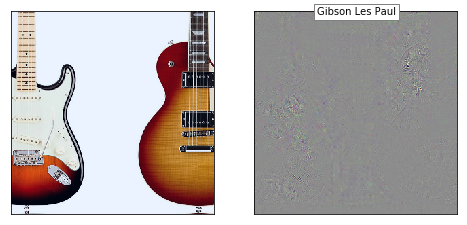

In [26]:
plot_prediction(data_cgbp[idx], idx, ptype='gbp', outname='plot_predict_cgbp.png')

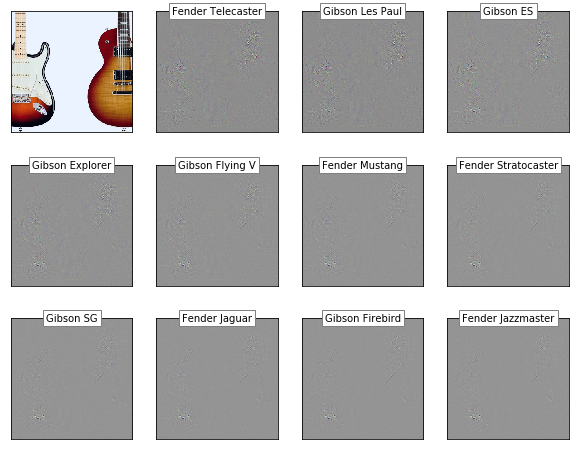

In [27]:
plot_panel(data_cgbp, ptype='gbp', outname='plot_panels_cgbp.png')

In [28]:
learn.model.eval()
tensor_img.requires_grad_()
learn.model.zero_grad()

data_combined = []

_min = min([x.min() for x in data_cam])
_max = max([x.max() for x in data_cam])
    
for i in range(11):

    prod = np.einsum('ijk, ij->ijk', data_cgbp[i], scale_data(data_cam[i], (_min,_max)))
    data_combined.append(prod)


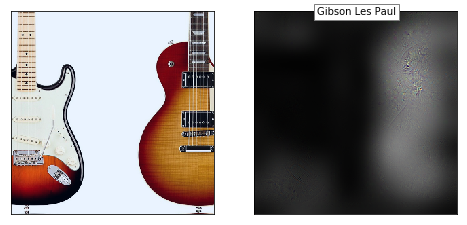

In [29]:
plot_prediction(data_combined[idx], idx, ptype='combi', outname='plot_predict_combined.png')

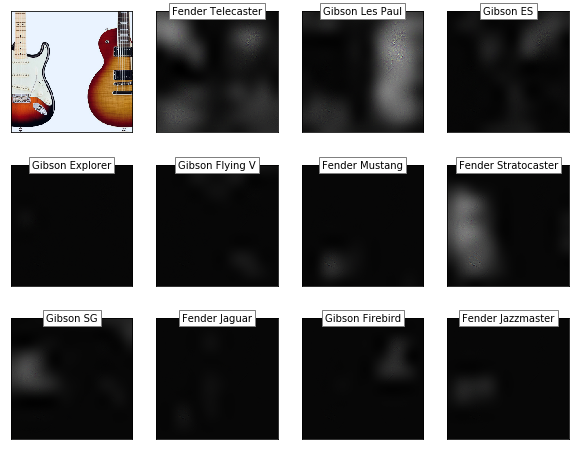

In [30]:
plot_panel(data_combined, ptype='combi', outname='plot_panels_combined.png')

Notebook based on the excellent work of @henripal:    
https://github.com/henripal/maps/blob/master/nbs/big_resnet50-interpret-gradcam.ipynb  